In [6]:
import requests
import os

def download_wav_file(url, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    # Extract the filename from the URL
    filename = url.split('/')[-1]
    
    # Construct the destination path
    destination_path = os.path.join(destination_dir, filename)
    
    # Send a GET request to the URL with a user-agent header
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Write the content of the response to the destination file
        with open(destination_path, 'wb') as f:
            f.write(response.content)
        
        print(f"File downloaded to: {destination_path}")
    else:
        print(f"Failed to download file from {url}")

# Example usage
url = "https://upload.wikimedia.org/wikipedia/commons/7/78/1210secretmorzecode.wav"
destination_dir = "morse_wav"

download_wav_file(url, destination_dir)


File downloaded to: morse_wav\1210secretmorzecode.wav


In [44]:
from scipy.io import wavfile

sample_rate, audio = wavfile.read('morse_wav/1210secretmorzecode.wav')
print(f'sample_rate: {sample_rate}')
print(f'audio: \n{audio}')

sample_rate: 4000
audio: 
[255   0 255 ...   0 255   0]


### normalize and downsample the audio signal

In [45]:

import pandas as pd
pd.options.display.max_rows = 7

audio = audio[:sample_rate*2]
"""
Multiplying sample_rate by 2 gives the number of samples 
in a 2-second duration of audio.
Therefore, audio[:sample_rate*2] slices the audio array
to keep only the samples corresponding to the first 2 
seconds of audio
"""
audio

array([255,   0, 255, ..., 128, 128, 128], dtype=uint8)

In [46]:
import numpy as np

epsilon = 1e-10
audio = np.abs(audio - audio.max()/2) - .5
audio = (audio + epsilon) / audio.max()
audio = audio[::sample_rate//400]

"""
- np.abs(audio - audio.max()/2) calculates the absolute difference between 
  each sample of the audio array and half of the maximum value in the audio 
  array. This operation centers the audio signal around zero.
  Subtracting 0.5 further shifts the range of values so that they fall between
  -0.5 and 0.5. The result is stored back in the audio array.

- audio = audio / audio.max()
  This line normalizes the audio signal by dividing each sample by the maximum
  absolute value in the audio array. This operation scales the audio signal to 
  have values between -1 and 1.
  This is a common normalization technique used in signal processing to ensure 
  consistent amplitude levels.

- audio = audio[::sample_rate//400]
  This line performs downsampling of the audio signal.
  sample_rate//400 calculates the downsampling factor. Dividing sample_rate by 400 
  gives an approximate number of samples per 400 Hz frequency band.

- audio[::sample_rate//400] 
  uses array slicing with a step size of sample_rate//400. This selects every 
  sample_rate//400-th sample from the audio array.
  As a result, the audio signal is downsampled, reducing the number of samples while
  preserving frequency content. This can be useful for reducing computational 
  complexity or file size while maintaining essential information in the audio signal.
"""

audio[:5]

array([1., 1., 1., 1., 1.])

In [47]:
audio = pd.Series(audio, name='audio')
audio.index = 1000 * audio.index/sample_rate
audio.index.name = 'time(ms)'

print(f'audio:\n{audio}')

audio:
time(ms)
0.00      1.000000e+00
0.25      1.000000e+00
0.50      1.000000e+00
              ...     
199.25    7.874016e-13
199.50    7.874016e-13
199.75    7.874016e-13
Name: audio, Length: 800, dtype: float64


<Axes: xlabel='time(ms)'>

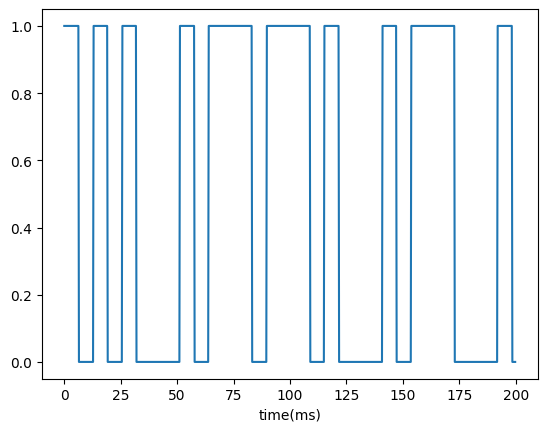

In [48]:
audio.plot()

### dot detecting kernel

In [49]:
def convolve(inpt, kernel):
    output = []
    for i in range(len(inpt) - len(kernel) + 1): 
        output.append( 
            sum(
                [
                    inpt[i + k] * kernel[k] 
                    for k in range(len(kernel))
                ] 
               ) 
        )
    return output

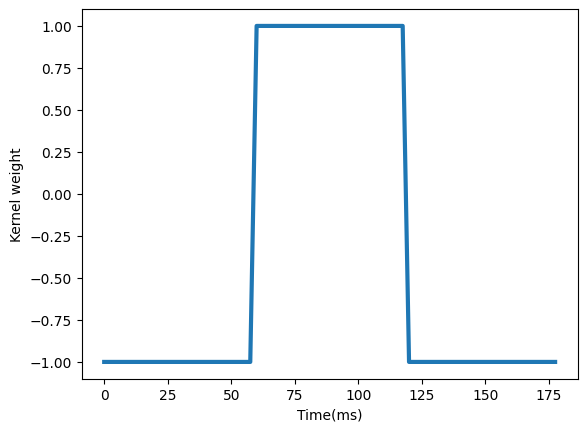

In [50]:
kernel = [-1]*24 + [1]*24 + [-1]*24
kernel = pd.Series(kernel, index=2.5*np.arange(len(kernel)))
kernel.index.name = 'Time(ms)'
ax = kernel.plot(linewidth=3, ylabel='Kernel weight')

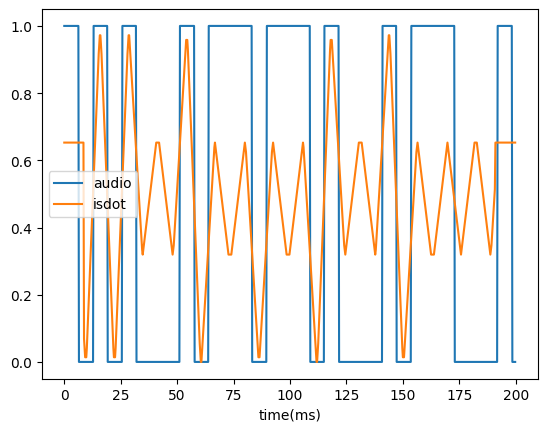

In [51]:
kernel = np.array(kernel)/sum(np.abs(kernel))
pad = [0] * (len(kernel)//2)
isdot = convolve(audio.values, kernel)
isdot = np.array(pad[:-1]+list(isdot)+pad)

df = pd.DataFrame()
df['audio'] = audio
df['isdot'] = isdot - isdot.min()
ax = df.plot()

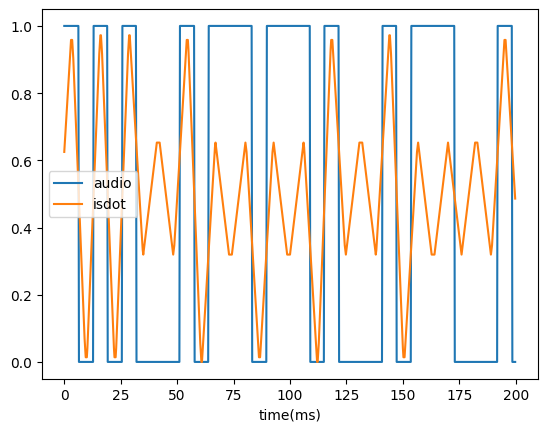

In [53]:
# or we can directly use the numpy convolve function

isdot = np.convolve(audio.values, kernel, mode='same')
df['isdot'] = isdot - isdot.min()
ax = df.plot()